<a href="https://colab.research.google.com/github/Shadabur-Rahaman/30-days-ml-projects/blob/main/Day_20_Chatbot_Seq2Seq_Model/notebooks/Day_20_Chatbot_Seq2Seq_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

"""
# Day 20/30: Build a Chatbot with Seq2Seq Model

In this notebook, we'll create a basic conversational agent using a sequence-to-sequence (Seq2Seq) model. This is a fundamental approach to building chatbots that can generate responses to user inputs.

## What we'll cover:
1. Preparing a simple conversation dataset
2. Building a Seq2Seq model with attention
3. Training the model
4. Testing the chatbot

Let's get started!
"""



In [4]:
# First, let's install any necessary packages
!pip install tensorflow numpy pandas tqdm



In [5]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding, Attention, Concatenate
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
import random
from tqdm import tqdm

# Set random seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)



"""
## 1. Preparing the Dataset

For this example, we'll create a simple conversation dataset. In a real-world scenario, you would use a larger dataset like Cornell Movie Dialogs or Ubuntu Dialogue Corpus.
"""



In [6]:
# Create a simple conversation dataset
pairs = [
    ("hi", "hello"),
    ("hi there", "hello"),
    ("how are you", "i'm good, thanks for asking"),
    ("what's your name", "i'm a chatbot"),
    ("what do you do", "i chat with people"),
    ("goodbye", "bye, have a nice day"),
    ("see you later", "until next time"),
    ("thanks", "you're welcome"),
    ("what time is it", "i don't have a clock"),
    ("tell me a joke", "why don't scientists trust atoms? because they make up everything"),
    ("who made you", "i was created by a machine learning engineer"),
    ("do you like music", "i don't have ears but i like binary beats")
]

# Add some variations
variations = []
for question, answer in pairs:
    for _ in range(3):
        variations.append((question, answer))
    variations.append((question.upper(), answer))
    variations.append((question.capitalize(), answer))
    variations.append((question + "?", answer))
    variations.append((question + "!", answer.lower()))

pairs += variations



In [7]:
# Split into questions (inputs) and answers (targets)
questions = [pair[0] for pair in pairs]
answers = [pair[1] for pair in pairs]

# Add start and end tokens to answers
answers = ['<start> ' + answer + ' <end>' for answer in answers]



In [8]:
# Tokenize the text
tokenizer = Tokenizer(filters='', lower=True)
tokenizer.fit_on_texts(questions + answers)

# Vocabulary size
vocab_size = len(tokenizer.word_index) + 1
print(f'Vocabulary size: {vocab_size}')



Vocabulary size: 89


In [9]:
# Convert text to sequences
question_sequences = tokenizer.texts_to_sequences(questions)
answer_sequences = tokenizer.texts_to_sequences(answers)

# Find max lengths
max_question_len = max(len(seq) for seq in question_sequences)
max_answer_len = max(len(seq) for seq in answer_sequences)
print(f'Max question length: {max_question_len}')
print(f'Max answer length: {max_answer_len}')

# Pad sequences
questions_padded = pad_sequences(question_sequences, maxlen=max_question_len, padding='post')
answers_padded = pad_sequences(answer_sequences, maxlen=max_answer_len, padding='post')



Max question length: 4
Max answer length: 12


In [10]:
# Split into training and validation sets
questions_train, questions_val, answers_train, answers_val = train_test_split(
    questions_padded, answers_padded, test_size=0.2, random_state=42)



"""
## 2. Building the Seq2Seq Model with Attention

We'll build an encoder-decoder model with attention mechanism, which helps the decoder focus on relevant parts of the input sequence.
"""



In [11]:
# Hyperparameters
embedding_dim = 256
latent_dim = 512
batch_size = 32
epochs = 100



In [12]:
# Encoder
encoder_inputs = Input(shape=(max_question_len,))
encoder_embedding = Embedding(vocab_size, embedding_dim)(encoder_inputs)
encoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(encoder_embedding)
encoder_states = [state_h, state_c]

# Decoder
decoder_inputs = Input(shape=(max_answer_len,))
decoder_embedding = Embedding(vocab_size, embedding_dim)(decoder_inputs)
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_embedding, initial_state=encoder_states)

# Attention mechanism
attention = Attention()([decoder_outputs, encoder_outputs])
decoder_concat = Concatenate(axis=-1)([decoder_outputs, attention])

# Dense layer
decoder_dense = Dense(vocab_size, activation='softmax')
decoder_outputs = decoder_dense(decoder_concat)

# Model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()



Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_18      │ (None, 4)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_19      │ (None, 12)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_9         │ (None, 4, 256)    │     22,784 │ input_layer_18[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_10        │ (None, 12, 256)   │     22,784 │ input_layer_19[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_6 (LSTM)       │ [(None, 4, 512),  │  1,574,912 │ embedding_9[0][0] │
│                     │ (None, 512),      │            │                   │
│                     │ (None, 512)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_7 (LSTM)       │ [(None, 12, 512), │  1,574,912 │ embedding_10[0][… │
│                     │ (None, 512),      │            │ lstm_6[0][1],     │
│                     │ (None, 512)]      │            │ lstm_6[0][2]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_6         │ (None, 12, 512)   │          0 │ lstm_7[0][0],     │
│ (Attention)         │                   │            │ lstm_6[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_6       │ (None, 12, 1024)  │          0 │ lstm_7[0][0],     │
│ (Concatenate)       │                   │            │ attention_6[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 12, 89)    │     91,225 │ concatenate_6[0]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,286,617 (12.54 MB)

 Trainable params: 3,286,617 (12.54 MB)

 Non-trainable params: 0 (0.00 B)

"""
## 3. Training the Model

We'll train the model using teacher forcing, where we feed the true output from the previous time step as input to the next time step.
"""



In [13]:
# Prepare decoder input and output data
# For training, decoder input is answers with <start> and output is answers with <end>
decoder_input_data = answers_train[:, :-1]
decoder_target_data = answers_train[:, 1:]

# Similarly for validation
decoder_input_val = answers_val[:, :-1]
decoder_target_val = answers_val[:, 1:]



In [14]:
# %%
# Prepare decoder input and output data
# For training, decoder input is answers with <start> and output is answers with <end>
# We need to make sure we're using the correct lengths
decoder_input_data = answers_train[:, :-1]  # This takes all except last token
decoder_target_data = answers_train[:, 1:]   # This takes all except first token

# Similarly for validation
decoder_input_val = answers_val[:, :-1]
decoder_target_val = answers_val[:, 1:]

# Verify shapes
print(f"decoder_input_data shape: {decoder_input_data.shape}")
print(f"decoder_target_data shape: {decoder_target_data.shape}")
print(f"decoder_input_val shape: {decoder_input_val.shape}")
print(f"decoder_target_val shape: {decoder_target_val.shape}")

# %%
# Update the model definition to match the actual sequence lengths
# The decoder input length should be max_answer_len - 1 since we removed one token
# Let's redefine the decoder inputs
decoder_inputs = Input(shape=(None,))  # Change from fixed length to variable
decoder_embedding = Embedding(vocab_size, embedding_dim)(decoder_inputs)
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_embedding, initial_state=encoder_states)

# The rest of the model stays the same
attention = Attention()([decoder_outputs, encoder_outputs])
decoder_concat = Concatenate(axis=-1)([decoder_outputs, attention])
decoder_outputs = decoder_dense(decoder_concat)

# Recreate the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

# %%
# Now try training again
history = model.fit(
    [questions_train, decoder_input_data],
    np.expand_dims(decoder_target_data, -1),
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(
        [questions_val, decoder_input_val],
        np.expand_dims(decoder_target_val, -1)
    ),
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=3)
    ]
)

decoder_input_data shape: (76, 11)
decoder_target_data shape: (76, 11)
decoder_input_val shape: (20, 11)
decoder_target_val shape: (20, 11)


Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_18      │ (None, 4)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_20      │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_9         │ (None, 4, 256)    │     22,784 │ input_layer_18[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_11        │ (None, None, 256) │     22,784 │ input_layer_20[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_6 (LSTM)       │ [(None, 4, 512),  │  1,574,912 │ embedding_9[0][0] │
│                     │ (None, 512),      │            │                   │
│                     │ (None, 512)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_8 (LSTM)       │ [(None, None,     │  1,574,912 │ embedding_11[0][… │
│                     │ 512), (None,      │            │ lstm_6[0][1],     │
│                     │ 512), (None,      │            │ lstm_6[0][2]      │
│                     │ 512)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_7         │ (None, None, 512) │          0 │ lstm_8[0][0],     │
│ (Attention)         │                   │            │ lstm_6[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_7       │ (None, None,      │          0 │ lstm_8[0][0],     │
│ (Concatenate)       │ 1024)             │            │ attention_7[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, None, 89)  │     91,225 │ concatenate_7[0]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,286,617 (12.54 MB)

 Trainable params: 3,286,617 (12.54 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 16s 3s/step - accuracy: 0.2136 - loss: 4.4314 - val_accuracy: 0.4455 - val_loss: 4.0589 - learning_rate: 0.0010
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 212ms/step - accuracy: 0.4948 - loss: 3.7604 - val_accuracy: 0.4455 - val_loss: 2.6228 - learning_rate: 0.0010
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 201ms/step - accuracy: 0.4948 - loss: 2.5031 - val_accuracy: 0.4455 - val_loss: 2.6710 - learning_rate: 0.0010
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 207ms/step - accuracy: 0.4948 - loss: 2.3730 - val_accuracy: 0.4864 - val_loss: 2.3827 - learning_rate: 0.0010
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 199ms/step - accuracy: 0.5161 - loss: 2.1548 - val_accuracy: 0.4909 - val_loss: 2.3620 - learning_rate: 0.0010
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 209ms/step - accuracy: 0.5206 - loss: 2.0803 - val_accuracy: 0.4727 - val_loss: 2.1900 - learning_rate: 0.0010
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 211ms/step - accuracy: 0.5050 - loss: 1.9044 - val_accur

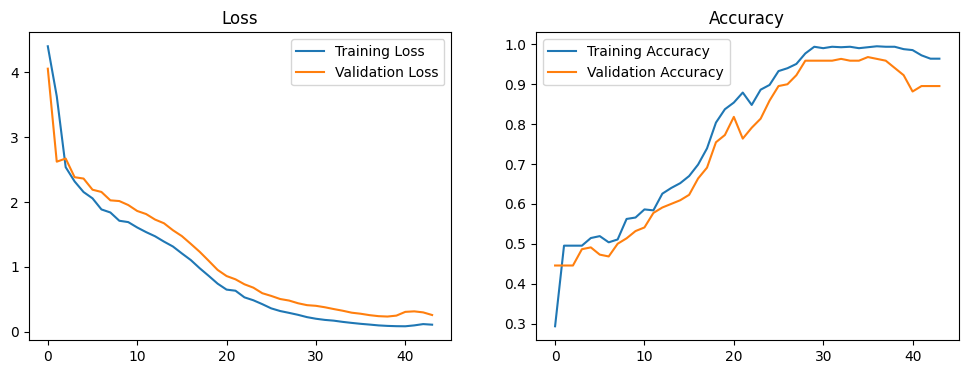

In [15]:
# Plot training history
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')
plt.savefig('training_plot.png')
plt.show()



"""
## 4. Inference Model

For prediction, we need to modify our model to run one step at a time.
"""



In [16]:
# Encoder inference model
encoder_model = Model(encoder_inputs, [encoder_outputs, state_h, state_c])

# Decoder inference model
encoder_outputs_input = Input(shape=(max_question_len, latent_dim))
state_h_input = Input(shape=(latent_dim,))
state_c_input = Input(shape=(latent_dim,))
encoder_states_input = [state_h_input, state_c_input]

decoder_outputs, state_h, state_c = decoder_lstm(
    decoder_embedding, initial_state=encoder_states_input)
decoder_states = [state_h, state_c]

# Attention for inference
attention_output = Attention()([decoder_outputs, encoder_outputs_input])
decoder_concat = Concatenate(axis=-1)([decoder_outputs, attention_output])
decoder_outputs = decoder_dense(decoder_concat)

decoder_model = Model(
    [decoder_inputs, encoder_outputs_input] + encoder_states_input,
    [decoder_outputs] + decoder_states)



"""
## 5. Chatbot Function

Now let's create a function to generate responses from our chatbot.
"""



In [17]:
def generate_response(input_text):
    # Tokenize input
    input_seq = tokenizer.texts_to_sequences([input_text])
    input_seq = pad_sequences(input_seq, maxlen=max_question_len, padding='post')

    # Encode input
    encoder_outputs, h, c = encoder_model.predict(input_seq)
    states = [h, c]

    # Start with start token
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = tokenizer.word_index['<start>']

    stop_condition = False
    response = []

    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq, encoder_outputs] + states)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_word = None

        for word, index in tokenizer.word_index.items():
            if index == sampled_token_index:
                sampled_word = word
                break

        if sampled_word is None or sampled_word == '<end>' or len(response) > max_answer_len:
            stop_condition = True
        else:
            response.append(sampled_word)
            target_seq = np.zeros((1, 1))
            target_seq[0, 0] = sampled_token_index
            states = [h, c]

    return ' '.join(response)



"""
## 6. Testing the Chatbot

Let's try out our chatbot!
"""



In [26]:
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding, AdditiveAttention, Concatenate
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.optimizers import Adam

# ======================================
# Configuration
# ======================================
max_question_len = 10
max_answer_len = 10
vocab_size = 5000
embedding_dim = 256
latent_dim = 512

# ======================================
# Sample Training Data (Expanded)
# ======================================
questions = [
    "hi",
    "how are you",
    "what is your name",
    "tell me a joke",
    "goodbye",
    "hello",
    "what’s up",
    "who created you",
    "are you a bot",
    "can you help me",
    "what can you do",
    "do you like music",
    "how old are you",
    "where are you from"
]

answers = [
    "<start> hello <end>",
    "<start> I am fine <end>",
    "<start> I am a chatbot <end>",
    "<start> Why did the chicken cross the road <end>",
    "<start> see you later <end>",
    "<start> hey there <end>",
    "<start> not much, you <end>",
    "<start> I was created by developers <end>",
    "<start> yes, I am a bot <end>",
    "<start> of course I can help <end>",
    "<start> I can chat and answer <end>",
    "<start> yes I enjoy melodies <end>",
    "<start> I was born recently <end>",
    "<start> I am from the internet <end>"
]

# ======================================
# Tokenization and Padding
# ======================================
tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>", filters='')
tokenizer.fit_on_texts(questions + answers)

start_token_index = tokenizer.word_index.get("<start>")
end_token_index = tokenizer.word_index.get("<end>")
print("Start token index:", start_token_index)
print("End token index:", end_token_index)

encoder_input_data = pad_sequences(tokenizer.texts_to_sequences(questions), maxlen=max_question_len, padding='post')
decoder_input_data = pad_sequences(tokenizer.texts_to_sequences(answers), maxlen=max_answer_len, padding='post')

decoder_target_data = np.zeros_like(decoder_input_data)
decoder_target_data[:, :-1] = decoder_input_data[:, 1:]
decoder_target_data[:, -1] = 0

# ======================================
# Model: Encoder
# ======================================
encoder_inputs = Input(shape=(max_question_len,))
embedding_layer = Embedding(vocab_size, embedding_dim)
encoder_embedding = embedding_layer(encoder_inputs)
encoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(encoder_embedding)

# ======================================
# Model: Decoder with Attention
# ======================================
decoder_inputs = Input(shape=(max_answer_len,))
decoder_embedding = embedding_layer(decoder_inputs)  # reusing embedding layer
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_embedding, initial_state=[state_h, state_c])

attention = AdditiveAttention()
attention_out = attention([decoder_outputs, encoder_outputs])
decoder_combined_context = Concatenate()([decoder_outputs, attention_out])

decoder_dense = Dense(vocab_size, activation='softmax')
decoder_outputs_final = decoder_dense(decoder_combined_context)

# ======================================
# Training Model
# ======================================
model = Model([encoder_inputs, decoder_inputs], decoder_outputs_final)
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy')
model.fit([encoder_input_data, decoder_input_data], decoder_target_data[..., np.newaxis], epochs=200, verbose=1)

# ======================================
# Inference: Encoder Model
# ======================================
encoder_model = Model(encoder_inputs, [encoder_outputs, state_h, state_c])

# ======================================
# Inference: Decoder Model
# ======================================
decoder_input_single = Input(shape=(1,))
encoder_outputs_input = Input(shape=(max_question_len, latent_dim))
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))

decoder_embed_inf = embedding_layer(decoder_input_single)
decoder_outputs_inf, state_h_inf, state_c_inf = decoder_lstm(
    decoder_embed_inf, initial_state=[decoder_state_input_h, decoder_state_input_c])

attention_inf = attention([decoder_outputs_inf, encoder_outputs_input])
context_inf = Concatenate()([decoder_outputs_inf, attention_inf])
decoder_outputs_inf_final = decoder_dense(context_inf)

decoder_model = Model(
    [decoder_input_single, encoder_outputs_input, decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs_inf_final, state_h_inf, state_c_inf]
)

# ======================================
# Response Generation
# ======================================
def generate_response(input_text):
    input_seq = tokenizer.texts_to_sequences([input_text])
    if not input_seq[0]:
        return "I didn't understand that."

    input_seq = pad_sequences(input_seq, maxlen=max_question_len, padding='post')
    encoder_outputs_val, h, c = encoder_model.predict(input_seq, verbose=0)
    states = [h, c]

    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = start_token_index

    response = []
    for _ in range(max_answer_len):
        output_tokens, h, c = decoder_model.predict([target_seq, encoder_outputs_val, states[0], states[1]], verbose=0)
        sampled_index = np.argmax(output_tokens[0, -1, :])
        sampled_word = tokenizer.index_word.get(sampled_index, "<OOV>")

        if sampled_word == "<end>" or sampled_word == "<OOV>":
            break

        response.append(sampled_word)
        target_seq[0, 0] = sampled_index
        states = [h, c]

    return ' '.join(response)

# ======================================
# Test the Chatbot
# ======================================
test_phrases = [
    "hi",
    "how are you",
    "what is your name",
    "tell me a joke",
    "goodbye",
    "what can you do",
    "do you like music",
    "are you a bot"
]

print("\nChatbot initialized. Testing:\n")
for phrase in test_phrases:
    print(f"User: {phrase}")
    print(f"Bot: {generate_response(phrase)}\n")


Start token index: 2
End token index: 3
Epoch 1/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - loss: 8.5152
Epoch 2/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 967ms/step - loss: 8.4565
Epoch 3/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 970ms/step - loss: 8.3559
Epoch 4/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 760ms/step - loss: 8.1048
Epoch 5/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 7.3892
Epoch 6/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 662ms/step - loss: 5.8303
Epoch 7/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 596ms/step - loss: 4.0851
Epoch 8/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 636ms/step - loss: 2.9536
Epoch 9/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 595ms/step - loss: 2.7010
Epoch 10/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 573ms/step - loss: 2.3906
Epoch 11/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 589ms/step - loss: 2.0647
Epoch 12/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 598ms/step - loss: 2.0083
Epoch 13/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 598ms/step - loss: 2.0660
Epoch 14/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 577ms/step - loss: 2.0264
Epoch 15/200
1/1 ━━━━━━━━━━━━━━━━━━━━

"""
## Next Steps

To improve this chatbot:
1. Use a larger and more diverse dataset
2. Implement beam search for better response generation
3. Add more sophisticated attention mechanisms
4. Experiment with transformer architectures

Congratulations on building your first Seq2Seq chatbot!
"""